In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
import matplotlib2tikz

In [3]:
torch.cuda.is_available()

True

In [4]:
from isaac.dataset import read_dataset, prepare_dataset
from isaac.utils import plot_confusion_matrix
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, MOUSE_CONTROL_COLS
from isaac.training import training_loop, evaluate_saved_model

In [5]:
BATCH_SIZE = 128
EPOCHS = 100
NORMALISE_DATA = True
STEP_SIZE = 3
SEQ_END = 1800

INPUT_DIM = len(BASIC_TRAINING_COLS) + len(MOUSE_CONTROL_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_params = (INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

In [6]:
question_type = "force"

## Read dataset and preprocess it

In [7]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

exp1_trials = [trial[:1801] for trial in exp1_trials]
all_trials = exp1_trials + exp2_mass_trials + exp2_force_trials

train_indices, val_indices = train_test_split(np.arange(len(all_trials)), test_size=0.25)
val_indices, test_indices = train_test_split(val_indices, test_size=0.5)

train_trials = [all_trials[idx] for idx in train_indices]
val_trials = [all_trials[idx] for idx in val_indices]
test_trials = [all_trials[idx] for idx in test_indices]

len(train_trials), len(val_trials), len(test_indices)

100%|██████████| 399/399 [00:07<00:00, 55.98it/s]


(762, 127, 128)

In [8]:
passive_trials = read_dataset("data/train_passive_trials.h5", n_trials=2500-len(train_trials))
passive_trials = [trial[:1801] for trial in passive_trials]

100%|██████████| 1738/1738 [00:17<00:00, 99.53it/s] 


In [9]:
for trial in tqdm(passive_trials):
    trial[list(MOUSE_CONTROL_COLS)] = False
    trial["C_none"] = True

100%|██████████| 1738/1738 [01:30<00:00, 19.28it/s]


In [10]:
train_trials += passive_trials

In [8]:
class MultiBranchModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MultiBranchModel, self).__init__()
        # RNN
        self.base_gru = nn.GRU(input_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        # Readout layer
        self.gru1 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.base_gru(x)
        
        out_1, _ = self.gru1(out)
        out_1 = self.fc1(out_1[:, -1, :]) 
        
        out_2, _ = self.gru2(out)
        out_2 = self.fc2(out_2[:, -1, :]) 
        return out_1, out_2

## Define model, loss and optimizer

In [12]:
def training_loop(model, optimizer, mass_error, force_error, train_loader, val_loader, num_epochs=200, print_stats_per_epoch=True,
                  seq_start=None, seq_end=None, step_size=None):    
    """Trains a model for <num_epochs> to minimize the <error> using the <optimizer>.
    Returns a list of epoch losses (averaged over batches) as well as validation accuracy"""
    
    best_model, best_mass_accuracy, best_force_accuracy = None, 0, 0
    epoch_losses = [[], []]
    epoch_accuracies = [[],[]]
    
    pbar = tqdm(range(num_epochs))
    
    for epoch in pbar:
        model.train()
        
        mass_total_loss = 0.
        force_total_loss = 0.

        for x, y in train_loader:

            x = Variable(x[:, seq_start:seq_end:step_size, :])
            y = Variable(y)
            
            mass_y = y[:, 0]
            force_y = y[:, 1]
            
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            mass_y_hat, force_y_hat = model(x)
            # Calculate softmax and cross entropy loss
            mass_loss = mass_error(mass_y_hat, mass_y)
            force_loss = force_error(force_y_hat, force_y)
            
            # Calculating gradients
            torch.autograd.backward([mass_loss, force_loss])
            
            # Update parameters
            optimizer.step()

            mass_total_loss += mass_loss.item()
            force_total_loss += force_loss.item()

        epoch_losses[0].append(mass_total_loss / len(train_loader))
        epoch_losses[1].append(force_total_loss / len(train_loader))

        model.eval()
        train_mass_accuracy, train_force_accuracy = evaluate(model, train_loader, seq_end=seq_end, step_size=step_size)
        epoch_accuracies[0].append((train_mass_accuracy, train_force_accuracy))
        val_mass_accuracy, val_force_accuracy = evaluate(model, val_loader, seq_end=seq_end, step_size=step_size)
        epoch_accuracies[1].append((val_mass_accuracy, val_force_accuracy))

        if val_mass_accuracy > best_mass_accuracy:
            best_mass_model = deepcopy(model)
            best_mass_accuracy = val_mass_accuracy
        
        if val_force_accuracy > best_force_accuracy:
            best_force_model = deepcopy(model)
            best_force_accuracy = val_force_accuracy
            
        if print_stats_per_epoch:
            pbar.set_description("Mass_loss (%.2f) Mass Train_acc (%.2f) Mass Val_acc (%.2f) Force_loss (%.2f)  Force Train_acc (%.2f) Force Val_acc (%.2f)" % 
                                 (epoch_losses[0][-1], train_mass_accuracy, val_mass_accuracy, 
                                  epoch_losses[1][-1], train_force_accuracy, val_force_accuracy))
    
    return epoch_losses, epoch_accuracies, [best_mass_model, best_force_model]

In [9]:
def get_current_prediction_and_number_of_correct_examples(y_hat, y_val):
    current_prediction = torch.max(y_hat.data, 1)[1]
    correct = (current_prediction == y_val).sum().cpu().numpy()
    return current_prediction, correct

def evaluate(model, val_loader, return_predicted=False, seq_start=None, seq_end=None, step_size=None):
    predicted = [[], []]
    accuracies = [[], []]

    mass_correct = 0
    force_correct = 0
    total = 0
    
    for x_val, y_val in val_loader:
        total += y_val.size(0)
        mass_val = y_val[:, 0]
        force_val = y_val[:, 1]

        x_val = Variable(x_val[:, seq_start:seq_end:step_size, :])
        mass_hat, force_hat = model(x_val)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(mass_hat, mass_val)
        mass_correct += correct
        predicted[0].extend(current_prediction)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(force_hat, force_val)
        force_correct += correct
        predicted[1].extend(current_prediction)
        
    accuracies[0] = 100 * mass_correct / float(total)
    accuracies[1] = 100 * force_correct / float(total)
    
    if return_predicted:
        return accuracies[0], accuracies[1], predicted[0], predicted[1]
    
    return accuracies[0], accuracies[1]

## Train model and plot loss and accuracy

In [14]:
def initialise_model(network_params, lr=0.01, seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = MultiBranchModel(*network_params)
    model = model.cuda()
    # model.load_state_dict(torch.load("models/passive_"+question_type+"_dual_model.pt"))
    
    mass_error = nn.CrossEntropyLoss().cuda()
    force_error = nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, mass_error, force_error, optimizer

In [15]:
def get_best_model_and_its_accuracy(accuracies, model, best_model, best_accuracy):
    model_accuracy = max(accuracies)
    print(model_accuracy)
    if model_accuracy > best_accuracy:
        return deepcopy(model), model_accuracy

    return best_model, best_accuracy

In [12]:
TR_COLS = list(BASIC_TRAINING_COLS) + list(MOUSE_CONTROL_COLS)

In [17]:
stats_dfs = []

loaders, scaler = prepare_dataset([train_trials, val_trials], 
                                  class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                  multiclass=True, training_columns=TR_COLS, categorical_columns=MOUSE_CONTROL_COLS,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)

best_mass_model_overall = None
best_mass_accuracy = 0.
best_force_model_overall = None
best_force_accuracy = 0.

for seed in [0, 42, 72]:
    df = pd.DataFrame()


    model, mass_error, force_error, optimizer = initialise_model(network_params, lr=0.01, seed=seed)
    epoch_losses, epoch_accuracies, [best_mass_model, best_force_model] = training_loop(model, optimizer, 
                                                                                        mass_error, force_error,
                                                                                        loaders[0], loaders[1], 
                                                                                        EPOCHS, seq_end=SEQ_END,
                                                                                        step_size=STEP_SIZE)

    train_accuracies = np.array(epoch_accuracies[0])
    val_accuracies = np.array(epoch_accuracies[1])
    
    best_mass_model_overall, best_mass_accuracy = get_best_model_and_its_accuracy(val_accuracies[:, 0], 
                                                                                  best_mass_model, 
                                                                                  best_mass_model_overall,
                                                                                  best_mass_accuracy)

    best_force_model_overall, best_force_accuracy = get_best_model_and_its_accuracy(val_accuracies[:, 1], 
                                                                                    best_force_model,
                                                                                    best_force_model_overall,
                                                                                    best_force_accuracy)

    df["Epoch"] = np.arange(EPOCHS)
    df["Mass Loss"] = epoch_losses[0]
    df["Force Loss"] = epoch_losses[1]
    df["Mass Train Accuracy"] = train_accuracies[:, 0]
    df["Mass Val Accuracy"] = val_accuracies[:, 0]
    df["Force Train Accuracy"] = train_accuracies[:, 1]
    df["Force Val Accuracy"] = val_accuracies[:,1]
    df["seed"] = str(seed)
    stats_dfs.append(df)
        
stats = pd.concat(stats_dfs)
stats.to_hdf("yoked_mixed_plots/stats.h5", key="stats")

100%|██████████| 127/127 [00:00<00:00, 260.06it/s]
Mass_loss (0.71) Mass Train_acc (63.64) Mass Val_acc (39.37) Force_loss (0.75)  Force Train_acc (57.52) Force Val_acc (44.09): 100%|██████████| 100/100 [09:15<00:00,  5.53s/it]
  0%|          | 0/100 [00:00<?, ?it/s]

51.181102362204726
53.54330708661417


Mass_loss (0.54) Mass Train_acc (73.68) Mass Val_acc (40.94) Force_loss (0.57)  Force Train_acc (72.52) Force Val_acc (40.94): 100%|██████████| 100/100 [09:10<00:00,  5.49s/it]
  0%|          | 0/100 [00:00<?, ?it/s]

51.181102362204726
51.968503937007874


Mass_loss (0.41) Mass Train_acc (82.80) Mass Val_acc (50.39) Force_loss (0.46)  Force Train_acc (79.72) Force Val_acc (44.88): 100%|██████████| 100/100 [09:15<00:00,  5.53s/it]

52.75590551181102
51.968503937007874


In [18]:
best_mass_accuracy, best_force_accuracy

(52.75590551181102, 53.54330708661417)

## Save model and scaler

In [19]:
torch.save(best_mass_model_overall.state_dict(), "models/yoked_mixed_mass_dual_model.pt")
torch.save(best_force_model_overall.state_dict(), "models/yoked_mixed_force_dual_model.pt")

In [20]:
joblib.dump(scaler, "scalers/yoked_mixed_dual_scaler.sk")

['scalers/yoked_mixed_dual_scaler.sk']

# Evaluating models on test data and CMs

In [10]:
def plot(predicted, i, class_columns, test_loader):
    predicted = [pred.cpu() for pred in predicted]
    Y_test = np.concatenate([y[:, i].cpu().numpy() for x, y in test_loader])

    # plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=False)
    plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=True, )

In [20]:
import seaborn as sns

sns.set_style("ticks")
sns.set_context("paper")
plt.rcParams.update({'axes.labelsize': '22',
                     'xtick.labelsize':'18',
                     'ytick.labelsize': '18',
                     'legend.fontsize': '18',
                     'figure.figsize': (8, 8),
                     'font.size': 22})

def increase_linewidth(ax):
    lines = ax.get_lines()
    for line in lines:
        line.set_linewidth(3)
    leg = ax.legend()
    leg_lines = leg.get_lines()
    plt.setp(leg_lines, linewidth=5)

100%|██████████| 128/128 [00:00<00:00, 296.20it/s]


45.3125


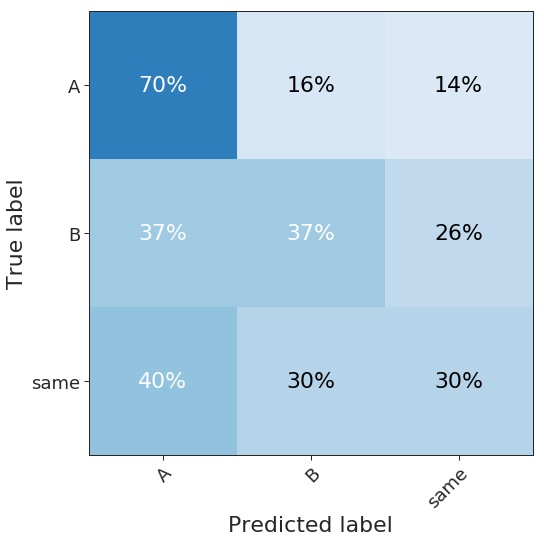

In [21]:
best_mass_model_overall = MultiBranchModel(*network_params)
best_mass_model_overall.load_state_dict(torch.load("models/yoked_mixed_mass_dual_model.pt"))
best_mass_model_overall.eval()
best_mass_model_overall = best_mass_model_overall.cuda()
scaler = joblib.load("scalers/yoked_mixed_dual_scaler.sk")

test_loader, _ = prepare_dataset([test_trials], class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                 training_columns=TR_COLS, multiclass=True, scaler=scaler,
                                 normalise_data=True, categorical_columns=MOUSE_CONTROL_COLS)
mass_accuracy, _, mass_predicted, _ = evaluate(best_mass_model_overall, test_loader, return_predicted=True, 
                                               seq_end=1800, step_size=3)
print(mass_accuracy)
plot(mass_predicted, 0, MASS_CLASS_COLS, test_loader)
plt.savefig("yoked_mixed_plots/mass_cm.pdf")

100%|██████████| 128/128 [00:00<00:00, 298.59it/s]


42.96875


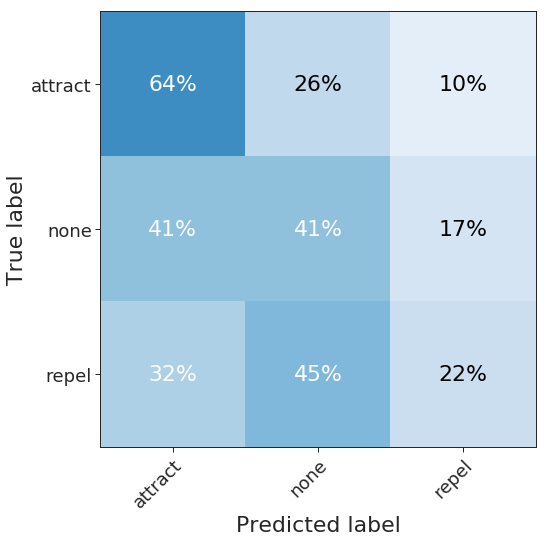

In [22]:
best_force_model_overall = MultiBranchModel(*network_params)
best_force_model_overall.load_state_dict(torch.load("models/yoked_mixed_force_dual_model.pt"))
best_force_model_overall.eval()
best_force_model_overall = best_force_model_overall.cuda()
scaler = joblib.load("scalers/yoked_mixed_dual_scaler.sk")

test_loader, _ = prepare_dataset([test_trials], class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                 training_columns=TR_COLS, multiclass=True, scaler=scaler,
                                 normalise_data=True,  categorical_columns=MOUSE_CONTROL_COLS)
_, force_accuracy, _, force_predicted = evaluate(best_force_model_overall, test_loader, return_predicted=True, seq_end=1800, step_size=3)
print(force_accuracy)
plot(force_predicted, 1, FORCE_CLASS_COLS, test_loader)
plt.savefig("yoked_mixed_plots/force_cm.pdf")